# Kentucky EPA Toxic Release Inventory Data Analysis
Authored by: Jessica Freeman, September 2021
GitHub Page URL: https://jmfr236.github.io/ky-tri-facilities/

As a part of the Toxic Release Inventory (TRI) Program, the EPA collects annual reports from large facility sites around the United States. These reports contain information about the amount of toxic chemicals a facility has released into the environment. This notebook takes a look at the number of Toxic Release Inventory facilities in Kentucky. Import US counties, rivers, and TRI 2014 data and clip data to Kentucky. Generate a pivot table to get the number of facilities within each county. Export modified data to geojson to add into leaflet map. 

Data Sources:
- Kentucky Counties - http://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip
- Kentucky Rivers - https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_10m_rivers_north_america.geojson
- Kentucky Toxic Release Inventory 2014 - https://query.data.world/s/3b3oi57gti4qhoexmg74sdc3ftz2te

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.speedups # can help speed up processes
from geopandas.tools import sjoin

plt.rcParams['figure.figsize'] = (15, 12)

## Import and Clip Data

In [2]:
# import data
us_counties = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip')
na_rivers = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_10m_rivers_north_america.geojson')

# toxic data invetory from https://data.world/dhs/epa-er-toxic-release-inventory
tri = pd.read_csv('https://query.data.world/s/3b3oi57gti4qhoexmg74sdc3ftz2te', index_col='FID')

In [3]:
# verify CRS
print(us_counties.crs) # output is {epsg:4269}
print(na_rivers.crs) # output is {epsg:4326}

# convert na_rivers to 4269
na_rivers.to_crs(epsg=4269, inplace=True)
na_rivers.crs
print(na_rivers.crs)

epsg:4269
epsg:4326
epsg:4269


In [4]:
# create a GeoDataFrame from the toxis reclease inventory CSV data and use the NAD 83 epsg:4269 CRS
geoms = [Point(xy) for xy in zip(tri.X, tri.Y)]
crs = {'init' :'epsg:4269'}
tri_geo = gpd.GeoDataFrame(tri, crs=crs, geometry=geoms)

print(tri_geo.crs)

C:\Users\jmfr236\Anaconda3\envs\674_07\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


+init=epsg:4269 +type=crs


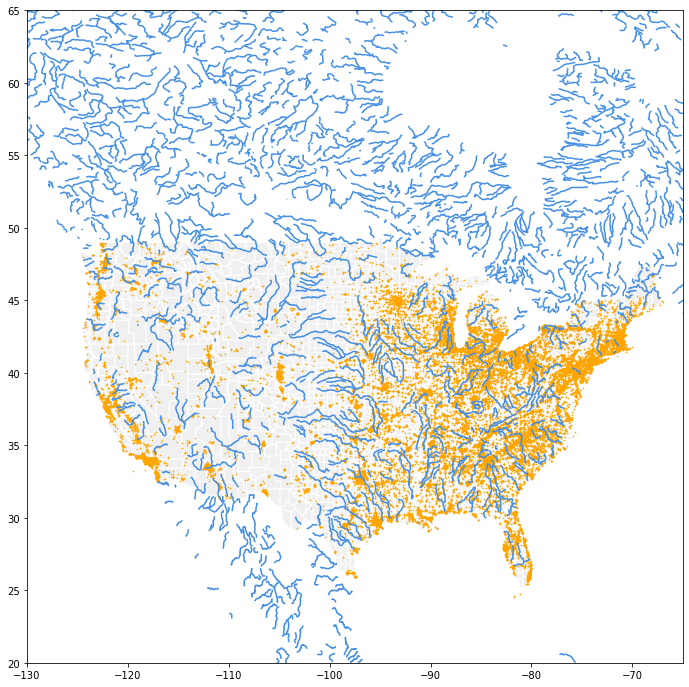

In [5]:
# plot the data
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

us_counties.plot(ax=ax, edgecolor='white', color=base_color);
tri_geo.plot(ax=ax, color='orange', zorder=1, markersize=.4)
na_rivers.plot(ax=ax, color=line_color, zorder=1);

ax.set(xlim=(-130,-65), ylim=(20,65));

In [6]:
# isolate kentucky
ky_counties = us_counties[us_counties['STUSPS'] == 'KY']

# create polygon to be used as a clipping mask of rivers
ky_poly = ky_counties.geometry.unary_union

In [7]:
# create new geodataframe of rivers that intersect us_poly
ky_rivers = na_rivers[na_rivers.geometry.intersects(ky_poly)]
ky_rivers.head()

,uident,strokeweig,scalerank,rivernum,dissolve,name,name_alt,note,name_full,featureclass,geometry
72,1905201,0.15,11,22654,22654River,Levisa Fk.,None,ID is link back to CEC data,Levisa Fork,River,"LINESTRING (-82.04857 37.25108, -82.08121 37.2..."
73,0,0.15,12,23279,23279River,Tug Fk.,None,None,Tug Fork,River,"LINESTRING (-81.96520 37.53868, -81.98388 37.5..."
75,1903501,0.15,11,22665,22665River,Licking,None,ID is link back to CEC data,Licking River,River,"LINESTRING (-82.94494 37.53526, -82.94107 37.5..."
76,1910301,0.15,12,22634,22634River,Mid. Fk. Kentucky,None,ID is link back to CEC data,Middle Fork Kentucky River,River,"LINESTRING (-83.40595 37.06855, -83.41723 37.0..."
77,1910001,0.15,10,22651,22651River,Green,None,ID is link back to CEC data,Green River,River,"LINESTRING (-84.67711 37.45535, -84.69392 37.4..."


In [8]:
# create new geodataframe of  that intersect us_poly
ky_tri = tri_geo[tri_geo.geometry.intersects(ky_poly)]

# add column extracting the year data of last report
ky_tri['LAST_REPORT'] =ky_tri['LAST_REPOR'].str[:4]
ky_tri.head()

C:\Users\jmfr236\Anaconda3\envs\674_07\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,X,Y,REGISTRY_I,PRIMARY_NA,LOCATION_A,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,POSTAL_COD,...,FAC_URL,PGM_SYS_ID,PGM_SYS_AC,INTEREST_T,ACTIVE_STA,PUBLIC_IND,PROGRAM_UR,PGM_REPORT,geometry,LAST_REPORT
FID,,,,,,,,,,,,,,,,,,,,,
15120,-85.727747,38.179200,110001236706,BREMNER INCORPORATED,1001 STANDIFORD LANE,LOUISVILLE,JEFFERSON,21111,KY,40213,...,http://oaspub.epa.gov/enviro/fac_gateway.main?...,40213BRMMR1001S,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-85.72775 38.17920),1997
15209,-85.521790,38.298740,110000378680,GCS GRINDMASTER CRATHCO SYSTEMS,4003 COLLINS LANE,LOUISVILLE,JEFFERSON,21111,KY,40245-1643,...,http://oaspub.epa.gov/enviro/fac_gateway.main?...,40245GRNDM4003C,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-85.52179 38.29874),2000
15214,-86.324556,37.029889,110020067595,BOWLING GREEN METALFORMING LLC,111 COSMA DR,BOWLING GREEN,WARREN,21227,KY,42101,...,http://oaspub.epa.gov/enviro/fac_gateway.main?...,42103BWLNG111CS,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-86.32456 37.02989),2014
15413,-85.472810,37.833030,110000377805,INTERTEC SYSTEMS INC,900 NUTTER DR.,BARDSTOWN,NELSON,21179,KY,400042604,...,http://oaspub.epa.gov/enviro/fac_gateway.main?...,40004WDRDG900NU,TRIS,TRI REPORTER,CLOSED,Y,http://www.epa.gov/tri/,no data yet,POINT (-85.47281 37.83303),2009
15425,-85.744660,38.228720,110000745622,FORTH TECHNOLOGIES INC,600 BERGMAN AVE.,LOUISVILLE,JEFFERSON,21111,KY,40203-2601,...,http://oaspub.epa.gov/enviro/fac_gateway.main?...,40203FRTHT600BE,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-85.74466 38.22872),2014


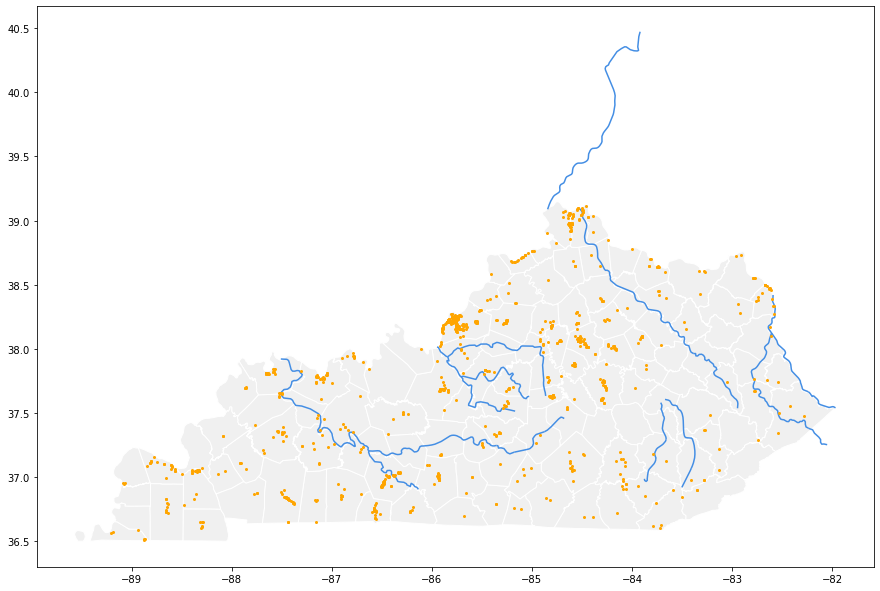

In [9]:
# plot the data with river and tri clip, verify clip worked
fig, ax = plt.subplots()

base_color = '#f0f0f0'
marker_color = '#448ee4'

ky_counties.plot(ax=ax, edgecolor='white', color=base_color);
ky_tri.plot(ax=ax, color='orange', zorder=2, markersize=4)
ky_rivers.plot(ax=ax, color=line_color, zorder=1);

# ax.set(xlim=(-130,-65), ylim=(20,55));

## Join and Review Data

In [10]:
# update ky_counties Name column to 'COUNTY_NAM' and attributes to all uppercase for joining tables
# ky_counties
county_names = ky_counties.rename(columns={'NAME':'COUNTY_NAM'})
county_names['COUNTY_NAM']=county_names['COUNTY_NAM'].str.upper()
county_names.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,COUNTY_NAM,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,LOGAN,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
4,21,147,00516926,0500000US21147,21147,MCCREARY,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."
5,21,195,00516944,0500000US21195,21195,PIKE,Pike County,KY,Kentucky,06,2037621882,4756759,"POLYGON ((-82.73269 37.27150, -82.73063 37.273..."
6,21,127,00516910,0500000US21127,21127,LAWRENCE,Lawrence County,KY,Kentucky,06,1076387821,11582519,"POLYGON ((-83.02497 37.99269, -83.02365 37.993..."
235,21,151,00516919,0500000US21151,21151,MADISON,Madison County,KY,Kentucky,06,1132745819,15290482,"POLYGON ((-84.52564 37.76950, -84.52383 37.770..."


In [11]:
# total count of TRI inventory per ky county
tri_count=ky_tri.pivot_table(values='REGISTRY_I', index='COUNTY_NAM', aggfunc=pd.Series.nunique)
tri_count

,REGISTRY_I
COUNTY_NAM,
ADAIR,1
ALLEN,5
ANDERSON,6
BALLARD,3
BARREN,17
...,...
WASHINGTON,6
WAYNE,2
WEBSTER,3


In [12]:
# merge counties and tri counts 
tri_county_merge=county_names.merge(tri_count, on='COUNTY_NAM', how='left')
tri_county_merge.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,COUNTY_NAM,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,REGISTRY_I
0,21,141,00516917,0500000US21141,21141,LOGAN,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",9.0
1,21,147,00516926,0500000US21147,21147,MCCREARY,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",NaN
2,21,195,00516944,0500000US21195,21195,PIKE,Pike County,KY,Kentucky,06,2037621882,4756759,"POLYGON ((-82.73269 37.27150, -82.73063 37.273...",4.0
3,21,127,00516910,0500000US21127,21127,LAWRENCE,Lawrence County,KY,Kentucky,06,1076387821,11582519,"POLYGON ((-83.02497 37.99269, -83.02365 37.993...",2.0
4,21,151,00516919,0500000US21151,21151,MADISON,Madison County,KY,Kentucky,06,1132745819,15290482,"POLYGON ((-84.52564 37.76950, -84.52383 37.770...",22.0


In [13]:
# number of nulls 
tri_county_merge['REGISTRY_I'].isnull().values.sum()

15

In [14]:
# top 10 TRI counties
tri_county_top10 = tri_county_merge.sort_values(by=['REGISTRY_I'], ascending=False)[:10]
tri_county_top10

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,COUNTY_NAM,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,REGISTRY_I
35,21,111,00516902,0500000US21111,21111,JEFFERSON,Jefferson County,KY,Kentucky,06,986271740,43513298,"POLYGON ((-85.94711 38.00509, -85.94222 38.007...",178.0
79,21,015,00516854,0500000US21015,21015,BOONE,Boone County,KY,Kentucky,06,637882924,26460891,"POLYGON ((-84.89691 39.05747, -84.89493 39.060...",42.0
72,21,227,00516960,0500000US21227,21227,WARREN,Warren County,KY,Kentucky,06,1403039303,15145759,"POLYGON ((-86.67446 36.99977, -86.66674 37.019...",39.0
18,21,067,00516880,0500000US21067,21067,FAYETTE,Fayette County,KY,Kentucky,06,734617508,4920615,"POLYGON ((-84.65766 38.01788, -84.64926 38.043...",38.0
50,21,101,00516897,0500000US21101,21101,HENDERSON,Henderson County,KY,Kentucky,06,1130079863,75695856,"POLYGON ((-87.92709 37.90170, -87.92174 37.907...",26.0
114,21,047,00516870,0500000US21047,21047,CHRISTIAN,Christian County,KY,Kentucky,06,1858342356,16919159,"POLYGON ((-87.73337 37.00210, -87.71101 37.021...",26.0
14,21,059,00516876,0500000US21059,21059,DAVIESS,Daviess County,KY,Kentucky,06,1187227811,46825915,"POLYGON ((-87.40529 37.68961, -87.40118 37.694...",25.0
57,21,093,00516893,0500000US21093,21093,HARDIN,Hardin County,KY,Kentucky,06,1614586535,17428816,"POLYGON ((-86.27756 37.58881, -86.27420 37.589...",23.0
115,21,117,00516905,0500000US21117,21117,KENTON,Kenton County,KY,Kentucky,06,415150789,10405456,"POLYGON ((-84.62348 39.07436, -84.62011 39.073...",23.0
4,21,151,00516919,0500000US21151,21151,MADISON,Madison County,KY,Kentucky,06,1132745819,15290482,"POLYGON ((-84.52564 37.76950, -84.52383 37.770...",22.0


In [15]:
year_pivot = ky_tri.pivot_table(values='REGISTRY_I', index='LAST_REPORT', aggfunc=pd.Series.nunique)
tri_county_merge.sort_values(by=['REGISTRY_I'], ascending=False)[:10]
year_pivot

,REGISTRY_I
LAST_REPORT,
1988,13
1989,13
1990,15
1991,25
1992,12
1993,19
1994,17
1995,34
1996,22


<AxesSubplot:title={'center':'Registry IDs Last Reported by Year'}, xlabel='LAST_REPORT'>

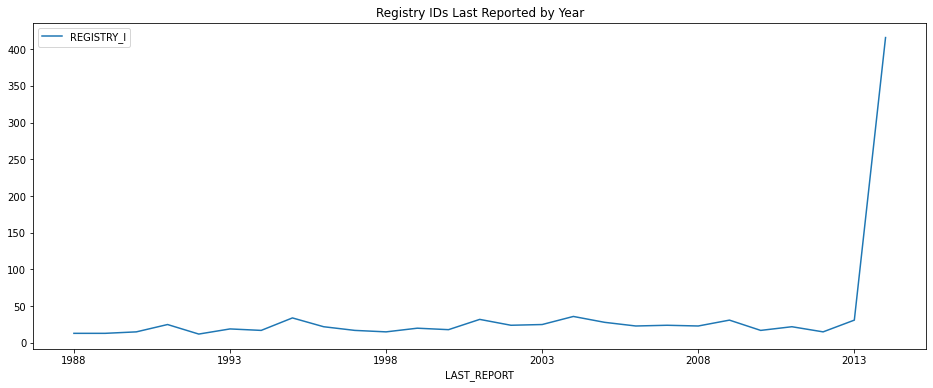

In [16]:
year_pivot.plot(figsize=(16,6), title='Registry IDs Last Reported by Year')

## Export Data

In [17]:
ky_tri.to_csv('C:\\Users\\jmfr236\\Desktop\\MAP674\\map674-module-07-jmfr236\\major-rivers\\notebooks\\data\\tri_data.csv')
ky_tri.to_file('C:\\Users\\jmfr236\\Desktop\\MAP674\\map674-module-07-jmfr236\\major-rivers\\notebooks\\data\\tri_data.json', driver='GeoJSON')
ky_rivers.to_file('C:\\Users\\jmfr236\\Desktop\\MAP674\\map674-module-07-jmfr236\\major-rivers\\notebooks\\data\\ky_rivers.json', driver='GeoJSON')
tri_county_merge.to_file('C:\\Users\\jmfr236\\Desktop\\MAP674\\map674-module-07-jmfr236\\major-rivers\\notebooks\\data\\tri_county_merge.json', driver='GeoJSON')